<!-- Banner Image -->
<img src="https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdevnotebooks.png" width="100%">

<!-- Links -->
<center>
  <a href="https://console.brev.dev" style="color: #06b6d4;">Console</a> •
  <a href="https://brev.dev" style="color: #06b6d4;">Docs</a> •
  <a href="/" style="color: #06b6d4;">Templates</a> •
  <a href="https://discord.gg/NVDyv7TUgJ" style="color: #06b6d4;">Discord</a>
</center>

# Export your Fine-Tuned Model to GGUF to Run Locally 🤙

Welcome!

We will export a checkpoint from our fine-tuned model ([Fine-tune Mistral 7B on your own data](), [Fine-tune Mistral 7B on HF dataset](), [Fine-tune Llama 2 on your own data]()) to a GGUF (the updated version of GGML) file. This will allow you to run your model locally, on your CPU, and/or on any GPUs your machine may have. You can also upload it to local LLM UI applications like [Ollama](https://ollama.ai/).

### Help us make this tutorial better! Please provide feedback on [Discord](https://discord.gg/NVDyv7TUgJ) or on [X](https://x.com/harperscarroll).

## Let's begin!

I used a GPU and dev environment from [brev.dev](https://brev.dev). Click the badge below to get your preconfigured instance:

[![ Click here to deploy.](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/environment/new?instance=A10G:g5.xlarge&diskStorage=256&name=gguf-export&file=https://github.com/brevdev/notebooks/raw/main/gguf-export.ipynb&python=3.10&cuda=12.0.1)

Once you've checked out your machine and landed in your instance page, select the specs you'd like (I used Python 3.10 and CUDA 12.0.1; these should be preconfigured for you if you use the badge above) and click the "Build" button to build your verb container. Give this a few minutes.

A few minutes after your model has started Running, click the 'Notebook' button on the top right of your screen once it illuminates (you may need to refresh the screen). You will be taken to a Jupyter Lab environment, where you can upload this Notebook.

Note: You can connect your cloud credits (AWS or GCP) by clicking "Org: " on the top right, and in the panel that slides over, click "Connect AWS" or "Connect GCP" under "Connect your cloud" and follow the instructions linked to attach your credentials.

## 1. Save Model, Tokenizer, and LoRA Checkpoint
First, we want to create a script to save the model, tokenizer, and LoRA checkpoint (which you have uploaded) to a file that we can then transform to GGUF.

In [11]:
!pip install transformers torch torchvision torchaudio peft accelerate sentencepiece gguf
!pip install -U git+https://github.com/huggingface/peft.git

In [9]:
%%writefile save_model.py
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import os
import torch
import argparse
 
def main():
 
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", type=str)
    parser.add_argument("--lora", type=str)
    parser.add_argument("--out_dir", type=str, default="./model") # leave this
    args = parser.parse_args()
 
    print(f"Loading base model: {args.model}")
    base_model = AutoModelForCausalLM.from_pretrained(args.model, torch_dtype=torch.float16, device_map="auto")
 
    print(f"Loading PEFT: {args.lora}")
    model = PeftModel.from_pretrained(base_model, args.lora)
    print(f"Running merge_and_unload")
    model = model.merge_and_unload()
    tokenizer = AutoTokenizer.from_pretrained(args.model)
 
    model.save_pretrained(f"{args.out_dir}")
    tokenizer.save_pretrained(f"{args.out_dir}")
    print(f"Model saved to {args.out_dir}")
 
if __name__ == "__main__" :
    main()

Overwriting save_model.py


Next, we run the script. Replace `mistralai/Mistral-7B-v0.1` and `checkpoint-500` below with the names of the correct Hugging Face base model, and your appropriate checkpoint number. Recall the `checkpoint-[STEP#]` directory should look like this:

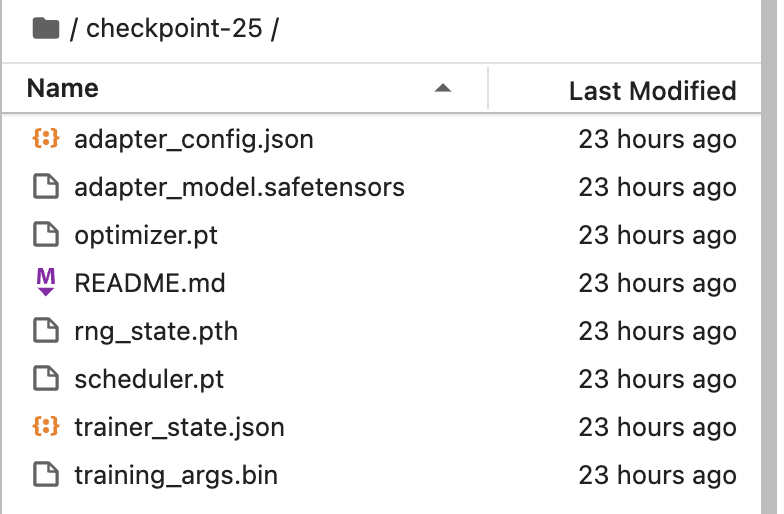

In [11]:
!python save_model.py --model 'mistralai/Mistral-7B-v0.1' --lora 'checkpoint-500' 

Loading base model: mistralai/Mistral-7B-v0.1
Loading checkpoint shards: 100%|██████████████████| 2/2 [01:58<00:00, 59.32s/it]
Loading PEFT: checkpoint-500
Running merge_and_unload
Model saved to ./model


## 2. Convert to GGUF 
Now we convert to GGUF using the `llama.cpp` `convert.py` script.

In [ ]:
!curl -L -o convert.py https://github.com/ggerganov/llama.cpp/raw/master/convert.py
!curl -L -o requirements.txt https://github.com/ggerganov/llama.cpp/raw/master/requirements.txt

!pip install -r requirements.txt

# Convert the 7B model to ggml FP16 format
!python3 convert.py model

## Code below is optional - uncomment (remove leftmost '# ') to use

# # [Optional] for models using BPE tokenizers
# !python convert.py model --vocabtype bpe

# # [Optional] quantize the model to 4-bits (using q4_0 method)
# !./quantize ./model/ggml-model-f16.gguf ./model/ggml-model-q4_0.gguf q4_0

# # [Optional] update the gguf filetype to current if older version is unsupported by another application
# !./quantize ./model/ggml-model-q4_0.gguf ./model/ggml-model-q4_0-v2.gguf COPY

### Excellent! Now you have the GGUF file. 
This can be uploaded to Oobabooga (an LLM user interface, akin to Stable Diffusion's AUTOMATIC1111) - see tutorial [here](https://github.com/brevdev/notebooks/blob/main/oobabooga.ipynb) - or you can run from the command line using [Ollama](https://ollama.ai/). For Ollama instructions, click [here](https://github.com/jmorganca/ollama#customize-your-own-model).

## 3. Optional: Save to your Local Machine

If you'd like to download the model to your local machine, open up your favorite shell on your local machine (or choose the application "Terminal" if you're not familiar) and enter the command:

`scp ubuntu@export-ggml:~/model/ggml-model-f16.gguf ~/Desktop`

This assumes an instance name `export-ggml`, the gguf file is named `ggml-model-f16.gguf` and it is in a `model` directory within your home directory, and you'd like to save it to your local Desktop. **This download will take a while, probably a few hours.**

Great! Now you've downloaded the `gguf` file for your fine-tuned model, which you can run locally on your machine. Again, services like [Ollama](https://ollama.ai/) are great for this. 


## I hope you enjoyed this tutorial!

I hope you enjoyed this tutorial on downloading your fine-tuned model as a GGUF file. If you have any questions, feel free to reach out to me on [X](https://x.com/harperscarroll) or on [Discord](https://discord.gg/NVDyv7TUgJ).

🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙